In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11_MS

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [3]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
img_2m_toa = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=False)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [4]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]

In [6]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)


#DG
# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1460.1287, 1452.7002, 1511.6293, 2497.181], 
              std=[672.7396, 743.9062, 918.4014, 1196.6774])
])

# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1545.9403, 1460.1287, 1452.7002, 1466.6466, 1511.6293, 1902.1776, 2497.181, 2167.458], 
              std=[512.423, 672.7396, 743.9062, 840.52625, 918.4014, 828.56976, 1196.6774, 1061.4962])
])

dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform, comb='all') # will return RGB by default
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform, comb='all')
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform, comb='all')

In [9]:
# some functions to write the data
def gt_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 1,
        "dtype": rio.uint8,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

def dg_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 8,
        "dtype": rio.float32,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename


# iterate over the data
cnt=0
for chipset, typ in zip( ((gt_dataset_train, dg_dataset_train), (gt_dataset_val, dg_dataset_val), (gt_dataset_test, dg_dataset_test)), ('train', 'val', 'test') ):
    
    # construct the base folder
    base_folder = '../tiles_64x64/{}'.format(typ)
    if not os.path.exists(base_folder):
        os.mkdir(base_folder)
        
    # separate the chipsets
    gt_set, dg_set = chipset
    
    print('chipping {} set'.format(typ))
    # iterate over the chipsets
    for gt_tensor, dg_tensor in zip(gt_set, dg_set):
    
        # write out the ground truth rasters
        #gt_name = 'gt_is_{0:05d}.tif'.format(cnt)
        #gt_fi = os.path.join(base_folder, gt_name)
        #gt_write(gt_fi, gt_tensor.numpy().astype('uint8'))
        
        # write out the dg rasters
        dg_name = 'dg_is_{0:05d}.tif'.format(cnt)
        dg_fi = os.path.join(base_folder, dg_name)
        dg_write(dg_fi, dg_tensor.numpy().astype('float32'))
        
        cnt+=1
        
        
        
        


chipping train set


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset uses default geotransform (Affine.identity). No transform will be written to the output by GDAL.
  s.start()


chipping val set
chipping test set


# DEBUG MISSING PIXELS

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(8, 64, 64)


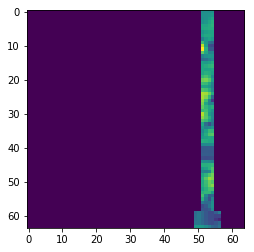

(1, 64, 64)


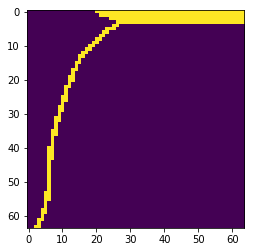

In [13]:
gt_files = glob.glob('../tiles_64x64/train/gt*.tif')
dg_files = glob.glob('../tiles_64x64/train/dg*.tif')
ind=1

with rio.open(dg_files[ind]) as src:
    arr = src.read()
    print(arr.shape)
    
plt.imshow(arr[5])
plt.show()

with rio.open(gt_files[ind]) as src:
    arr = src.read()
    print(arr.shape)
    
plt.imshow(arr[0])

row start: 1042, row end: 1106
col start: 1839, col end: 1903
imshape: (2352, 3231)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


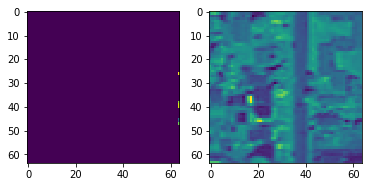

In [16]:
ind=2
r,c = coords[ind]
window_size=64
r_start = int(r - window_size/2)
r_end = int(r_start + window_size)
c_start = int(c - window_size/2)
c_end = int(c_start + window_size)

print('row start: {}, row end: {}'.format(r_start, r_end))
print('col start: {}, col end: {}'.format(c_start, c_end))
print('imshape: {}'.format(img_2m.shape[1:]))

test = img_2m[:,r_start:r_end, c_start:c_end]
test_toa = img_2m_toa[:,r_start:r_end, c_start:c_end]

fig, ax = plt.subplots(1,2)
ax[0].imshow(test[5,:,:])
ax[1].imshow(test_toa[5,:,:])
plt.show()

In [15]:
test.affine

Affine(1.7211642112827883e-05, 0.0, -105.03875758609415,
       0.0, -1.7211642112827883e-05, 39.70158674057851)

In [17]:
test.affine

Affine(1.7211642112827883e-05, 0.0, -105.01633081642113,
       0.0, -1.7211642112827883e-05, 39.71272267302552)

row start: 162, row end: 226
col start: 1436, col end: 1500
imshape: (2352, 3231)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


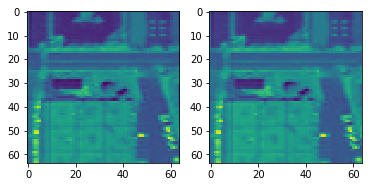

row start: 2160, row end: 2224
col start: 2955, col end: 3019
imshape: (2352, 3231)


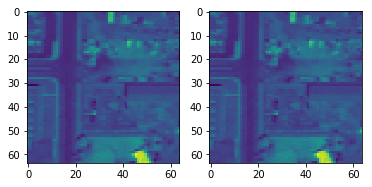

row start: 1444, row end: 1508
col start: 1939, col end: 2003
imshape: (2352, 3231)


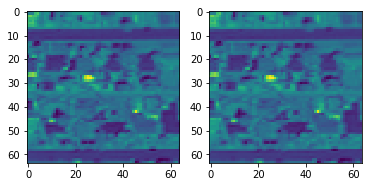

row start: 911, row end: 975
col start: 2429, col end: 2493
imshape: (2352, 3231)


KeyboardInterrupt: 

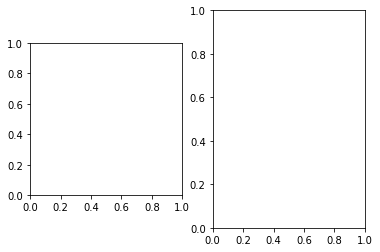

In [8]:
samp_inds = np.unique(np.random.randint(6000, size=100))
for ind in samp_inds:
    
    r,c = coords[ind]
    window_size=64
    r_start = int(r - window_size/2)
    r_end = int(r_start + window_size)
    c_start = int(c - window_size/2)
    c_end = int(c_start + window_size)
    
    print('row start: {}, row end: {}'.format(r_start, r_end))
    print('col start: {}, col end: {}'.format(c_start, c_end))
    print('imshape: {}'.format(img_2m.shape[1:]))
    
    test = img_2m[:,r_start:r_end, c_start:c_end]
    test_toa = img_2m_toa[:,r_start:r_end, c_start:c_end]
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(test[5,:,:])
    ax[1].imshow(test_toa[5,:,:])
    plt.show()

In [ ]:
dg_scene_id

In [37]:
with open('dg_support_coords.txt', 'w') as f:
    for item in coords:
        f.write("{} {}\n".format(item[0], item[1]))

row start: 522, row end: 586
col start: 1870, col end: 1934
imshape: (2352, 3231)


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


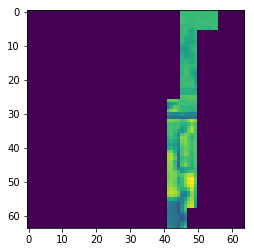

row start: 1659, row end: 1723
col start: 2959, col end: 3023
imshape: (2352, 3231)


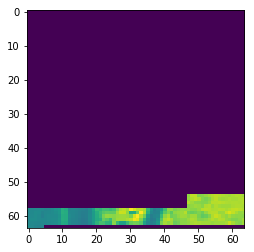

row start: 890, row end: 954
col start: 1523, col end: 1587
imshape: (2352, 3231)


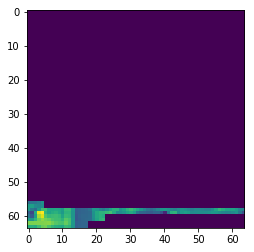

row start: 1732, row end: 1796
col start: 2549, col end: 2613
imshape: (2352, 3231)


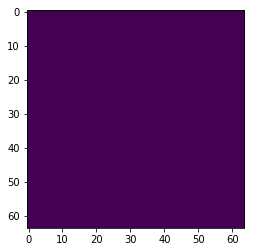

row start: 1388, row end: 1452
col start: 1236, col end: 1300
imshape: (2352, 3231)


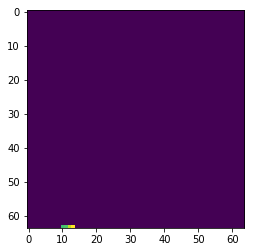

row start: 1353, row end: 1417
col start: 2571, col end: 2635
imshape: (2352, 3231)


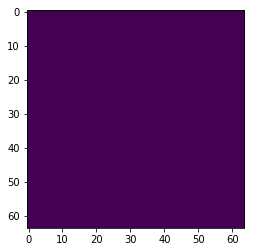

row start: 1501, row end: 1565
col start: 468, col end: 532
imshape: (2352, 3231)


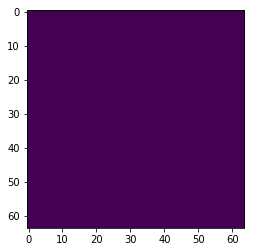

row start: 911, row end: 975
col start: 2132, col end: 2196
imshape: (2352, 3231)


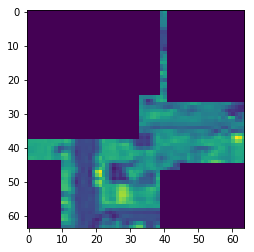

row start: 974, row end: 1038
col start: 2385, col end: 2449
imshape: (2352, 3231)


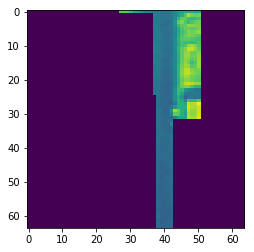

row start: 1468, row end: 1532
col start: 1705, col end: 1769
imshape: (2352, 3231)


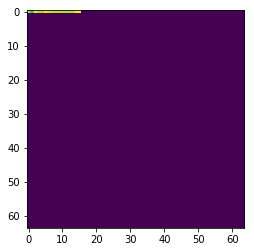

row start: 389, row end: 453
col start: 1759, col end: 1823
imshape: (2352, 3231)


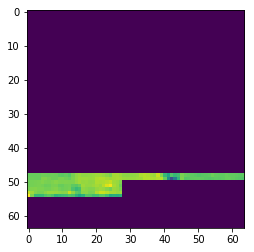

row start: 1493, row end: 1557
col start: 1748, col end: 1812
imshape: (2352, 3231)


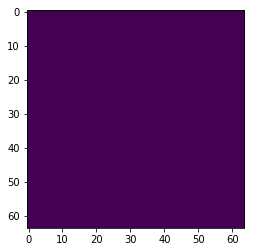

row start: 1016, row end: 1080
col start: 1978, col end: 2042
imshape: (2352, 3231)


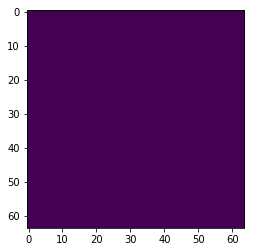

row start: 1910, row end: 1974
col start: 2741, col end: 2805
imshape: (2352, 3231)


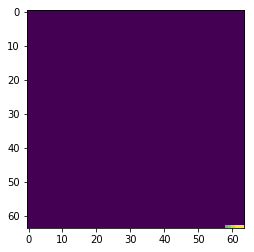

row start: 1206, row end: 1270
col start: 782, col end: 846
imshape: (2352, 3231)


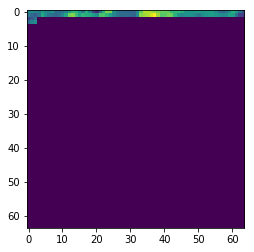

row start: 651, row end: 715
col start: 2109, col end: 2173
imshape: (2352, 3231)


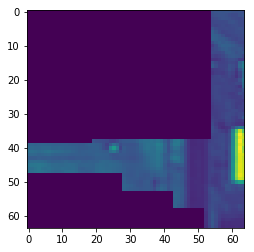

row start: 1193, row end: 1257
col start: 609, col end: 673
imshape: (2352, 3231)


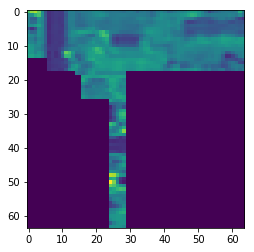

row start: 425, row end: 489
col start: 1886, col end: 1950
imshape: (2352, 3231)


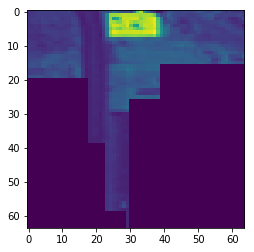

row start: 1399, row end: 1463
col start: 2096, col end: 2160
imshape: (2352, 3231)


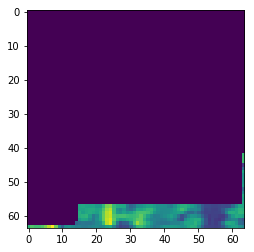

row start: 1625, row end: 1689
col start: 917, col end: 981
imshape: (2352, 3231)


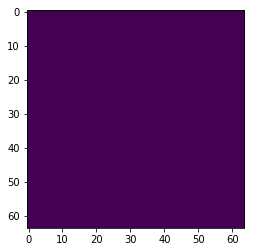

row start: 1205, row end: 1269
col start: 347, col end: 411
imshape: (2352, 3231)


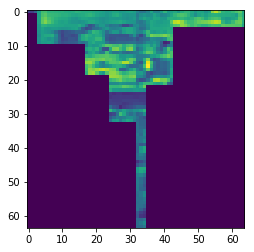

row start: 682, row end: 746
col start: 1830, col end: 1894
imshape: (2352, 3231)


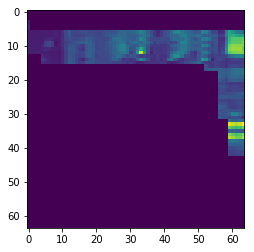

row start: 1197, row end: 1261
col start: 2474, col end: 2538
imshape: (2352, 3231)


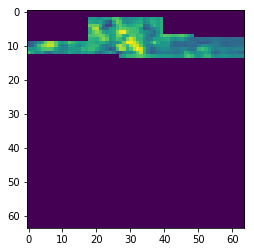

row start: 342, row end: 406
col start: 1769, col end: 1833
imshape: (2352, 3231)


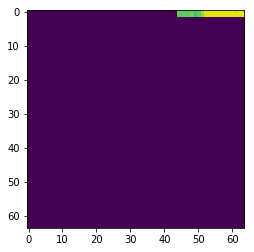

row start: 1617, row end: 1681
col start: 391, col end: 455
imshape: (2352, 3231)


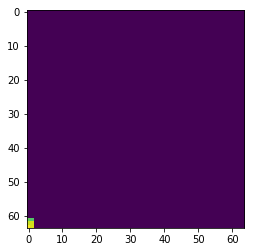

row start: 1564, row end: 1628
col start: 1471, col end: 1535
imshape: (2352, 3231)


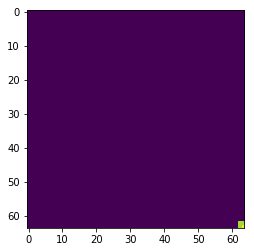

row start: 1188, row end: 1252
col start: 1118, col end: 1182
imshape: (2352, 3231)


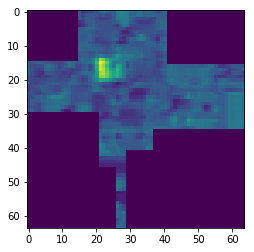

row start: 1105, row end: 1169
col start: 1897, col end: 1961
imshape: (2352, 3231)


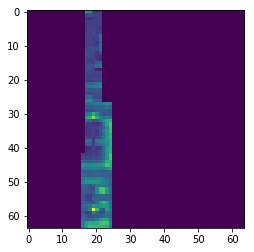

row start: 1285, row end: 1349
col start: 368, col end: 432
imshape: (2352, 3231)


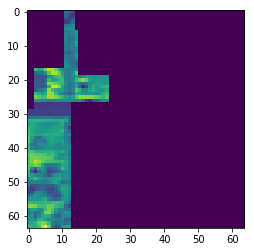

row start: 1102, row end: 1166
col start: 2086, col end: 2150
imshape: (2352, 3231)


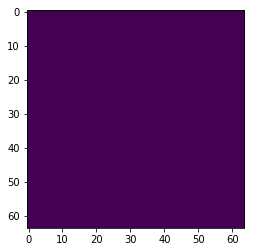

row start: 992, row end: 1056
col start: 2332, col end: 2396
imshape: (2352, 3231)


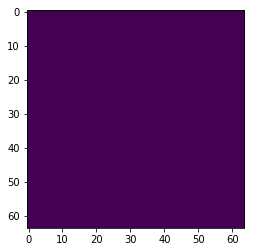

row start: 523, row end: 587
col start: 1431, col end: 1495
imshape: (2352, 3231)


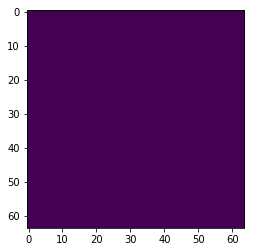

row start: 150, row end: 214
col start: 1747, col end: 1811
imshape: (2352, 3231)


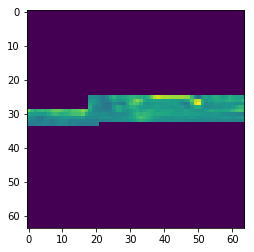

row start: 1685, row end: 1749
col start: 923, col end: 987
imshape: (2352, 3231)


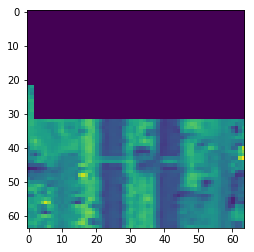

row start: 903, row end: 967
col start: 1384, col end: 1448
imshape: (2352, 3231)


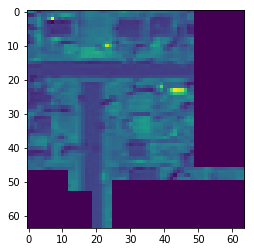

row start: 1212, row end: 1276
col start: 586, col end: 650
imshape: (2352, 3231)


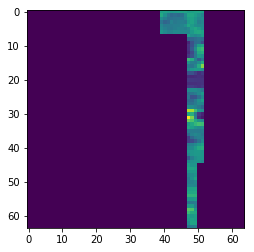

row start: 2154, row end: 2218
col start: 2985, col end: 3049
imshape: (2352, 3231)


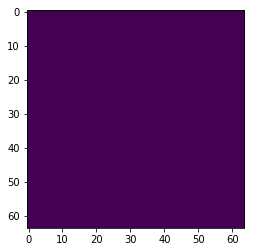

row start: 327, row end: 391
col start: 1748, col end: 1812
imshape: (2352, 3231)


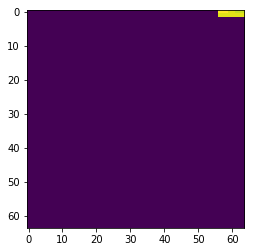

row start: 472, row end: 536
col start: 1478, col end: 1542
imshape: (2352, 3231)


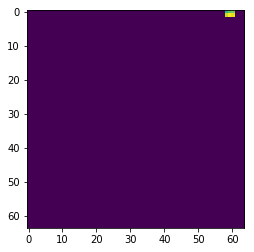

row start: 1323, row end: 1387
col start: 1290, col end: 1354
imshape: (2352, 3231)


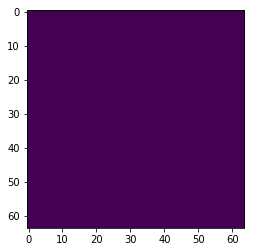

row start: 1345, row end: 1409
col start: 884, col end: 948
imshape: (2352, 3231)


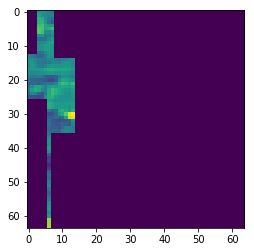

row start: 1155, row end: 1219
col start: 2666, col end: 2730
imshape: (2352, 3231)


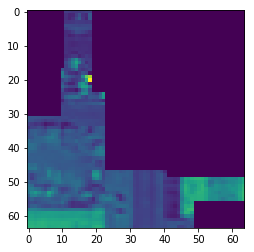

row start: 1628, row end: 1692
col start: 1193, col end: 1257
imshape: (2352, 3231)


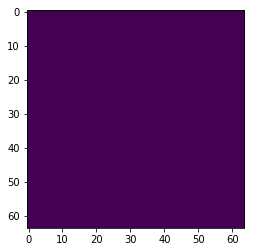

row start: 1887, row end: 1951
col start: 2701, col end: 2765
imshape: (2352, 3231)


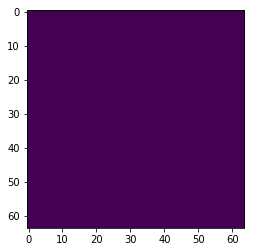

row start: 1202, row end: 1266
col start: 407, col end: 471
imshape: (2352, 3231)


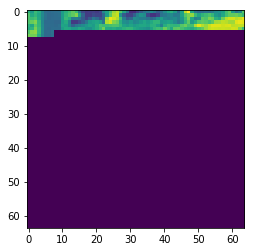

row start: 644, row end: 708
col start: 2234, col end: 2298
imshape: (2352, 3231)


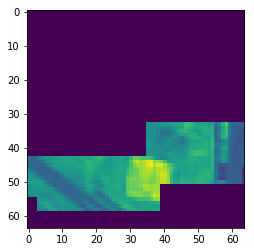

row start: 249, row end: 313
col start: 1745, col end: 1809
imshape: (2352, 3231)


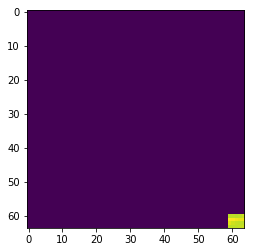

row start: 1142, row end: 1206
col start: 1362, col end: 1426
imshape: (2352, 3231)


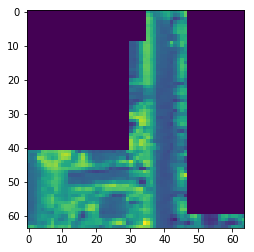

row start: 1216, row end: 1280
col start: 431, col end: 495
imshape: (2352, 3231)


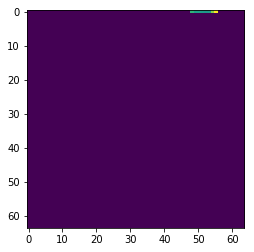

row start: 1154, row end: 1218
col start: 1118, col end: 1182
imshape: (2352, 3231)


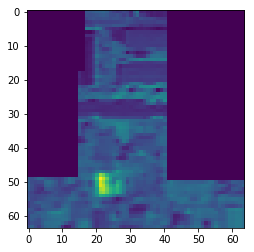

row start: 267, row end: 331
col start: 1584, col end: 1648
imshape: (2352, 3231)


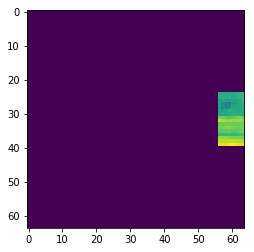

row start: 1526, row end: 1590
col start: 594, col end: 658
imshape: (2352, 3231)


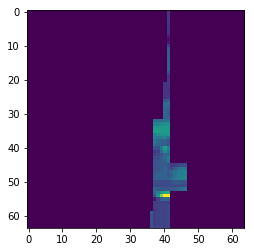

row start: 569, row end: 633
col start: 1870, col end: 1934
imshape: (2352, 3231)


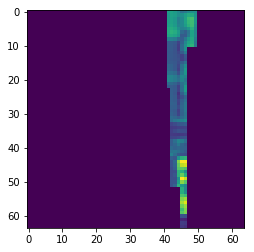

row start: 1484, row end: 1548
col start: 2092, col end: 2156
imshape: (2352, 3231)


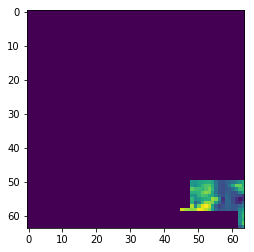

row start: 1126, row end: 1190
col start: 2587, col end: 2651
imshape: (2352, 3231)


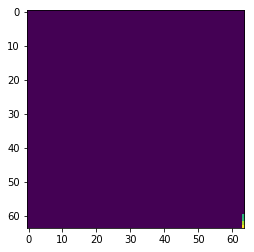

row start: 1649, row end: 1713
col start: 306, col end: 370
imshape: (2352, 3231)


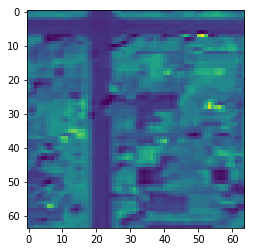

row start: 975, row end: 1039
col start: 2254, col end: 2318
imshape: (2352, 3231)


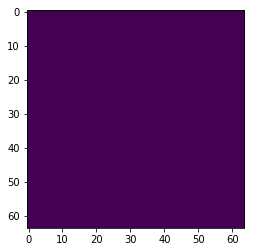

row start: 597, row end: 661
col start: 1844, col end: 1908
imshape: (2352, 3231)


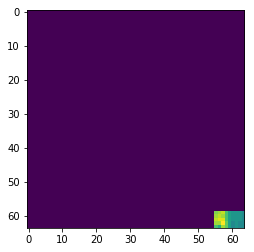

row start: 643, row end: 707
col start: 1952, col end: 2016
imshape: (2352, 3231)


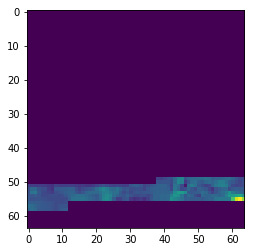

row start: 1261, row end: 1325
col start: 1796, col end: 1860
imshape: (2352, 3231)


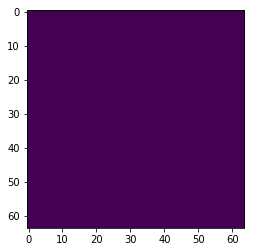

row start: 556, row end: 620
col start: 1456, col end: 1520
imshape: (2352, 3231)


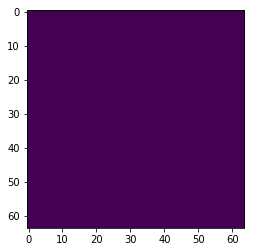

row start: 541, row end: 605
col start: 1574, col end: 1638
imshape: (2352, 3231)


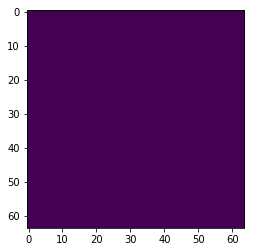

row start: 319, row end: 383
col start: 1582, col end: 1646
imshape: (2352, 3231)


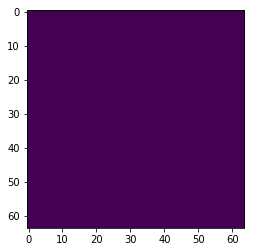

row start: 1481, row end: 1545
col start: 2660, col end: 2724
imshape: (2352, 3231)


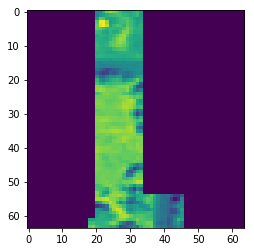

row start: 1896, row end: 1960
col start: 2739, col end: 2803
imshape: (2352, 3231)


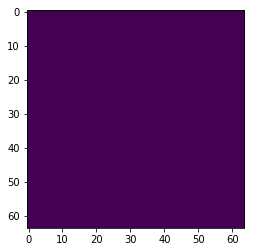

row start: 1528, row end: 1592
col start: 566, col end: 630
imshape: (2352, 3231)


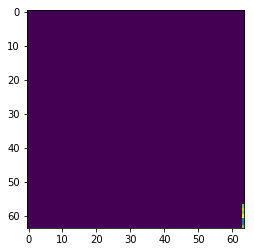

row start: 828, row end: 892
col start: 1523, col end: 1587
imshape: (2352, 3231)


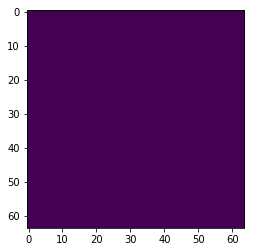

row start: 1181, row end: 1245
col start: 1709, col end: 1773
imshape: (2352, 3231)


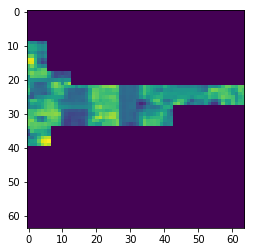

row start: 1023, row end: 1087
col start: 2115, col end: 2179
imshape: (2352, 3231)


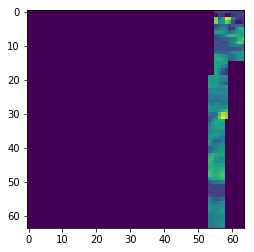

row start: 273, row end: 337
col start: 1687, col end: 1751
imshape: (2352, 3231)


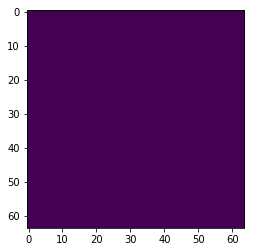

row start: 1047, row end: 1111
col start: 1712, col end: 1776
imshape: (2352, 3231)


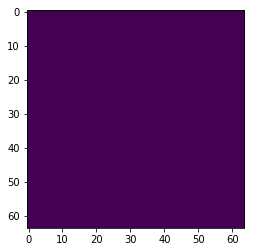

row start: 159, row end: 223
col start: 1461, col end: 1525
imshape: (2352, 3231)


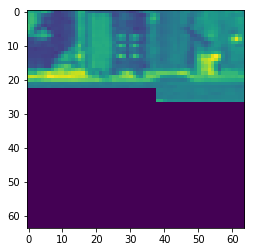

row start: 1687, row end: 1751
col start: 2813, col end: 2877
imshape: (2352, 3231)


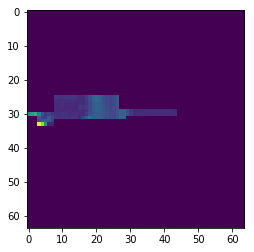

row start: 927, row end: 991
col start: 1776, col end: 1840
imshape: (2352, 3231)


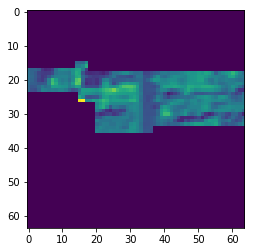

row start: 835, row end: 899
col start: 1355, col end: 1419
imshape: (2352, 3231)


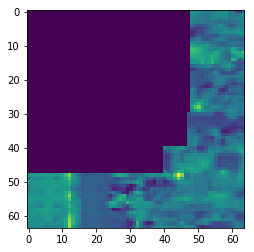

row start: 1898, row end: 1962
col start: 2897, col end: 2961
imshape: (2352, 3231)


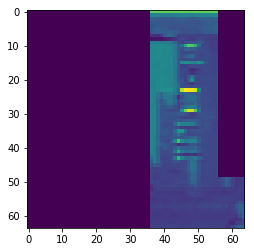

row start: 1261, row end: 1325
col start: 2552, col end: 2616
imshape: (2352, 3231)


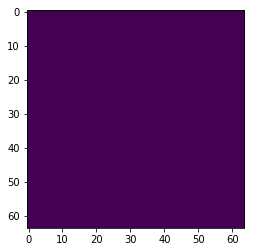

row start: 678, row end: 742
col start: 2278, col end: 2342
imshape: (2352, 3231)


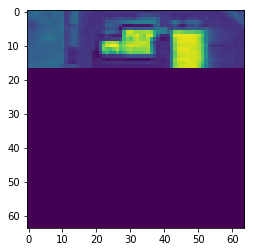

row start: 1514, row end: 1578
col start: 2035, col end: 2099
imshape: (2352, 3231)


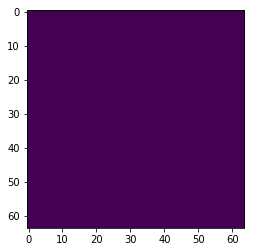

row start: 1271, row end: 1335
col start: 658, col end: 722
imshape: (2352, 3231)


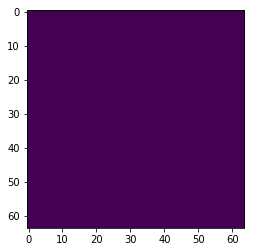

row start: 717, row end: 781
col start: 2144, col end: 2208
imshape: (2352, 3231)


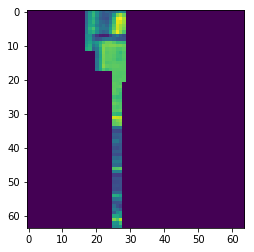

row start: 773, row end: 837
col start: 1933, col end: 1997
imshape: (2352, 3231)


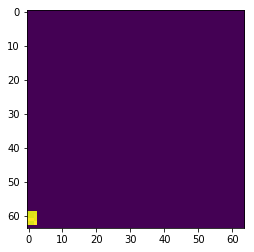

row start: 1591, row end: 1655
col start: 561, col end: 625
imshape: (2352, 3231)


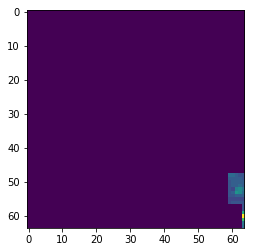

row start: 1229, row end: 1293
col start: 1213, col end: 1277
imshape: (2352, 3231)


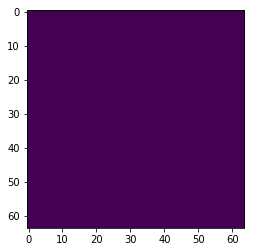

row start: 974, row end: 1038
col start: 1709, col end: 1773
imshape: (2352, 3231)


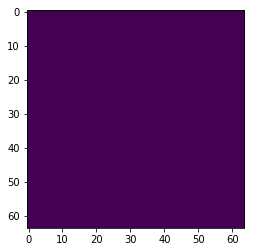

row start: 1510, row end: 1574
col start: 1092, col end: 1156
imshape: (2352, 3231)


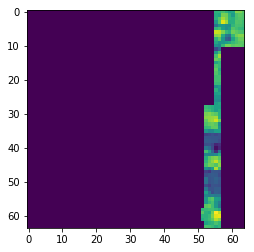

row start: 1381, row end: 1445
col start: 2561, col end: 2625
imshape: (2352, 3231)


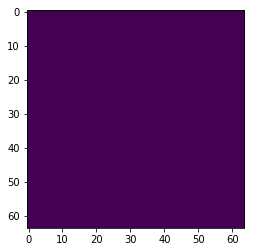

row start: 1799, row end: 1863
col start: 2890, col end: 2954
imshape: (2352, 3231)


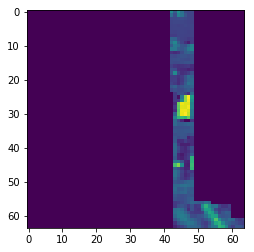

row start: 1181, row end: 1245
col start: 2701, col end: 2765
imshape: (2352, 3231)


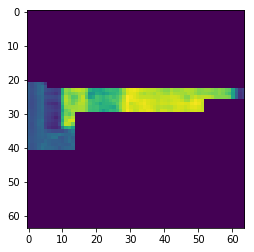

row start: 1454, row end: 1518
col start: 2510, col end: 2574
imshape: (2352, 3231)


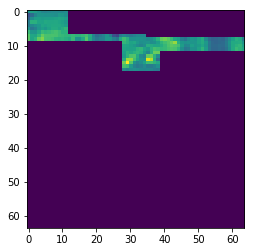

row start: 1589, row end: 1653
col start: 1105, col end: 1169
imshape: (2352, 3231)


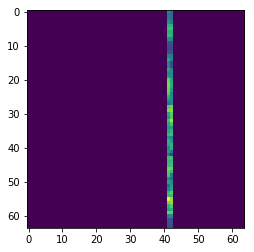

row start: 1826, row end: 1890
col start: 2811, col end: 2875
imshape: (2352, 3231)


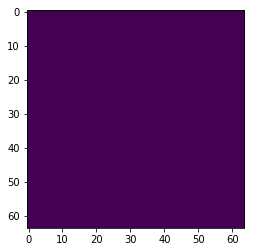

row start: 880, row end: 944
col start: 2294, col end: 2358
imshape: (2352, 3231)


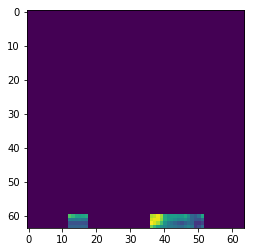

row start: 1290, row end: 1354
col start: 2756, col end: 2820
imshape: (2352, 3231)


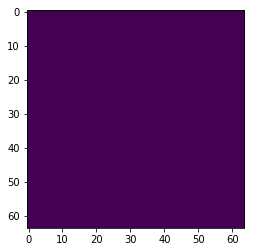

row start: 964, row end: 1028
col start: 1803, col end: 1867
imshape: (2352, 3231)


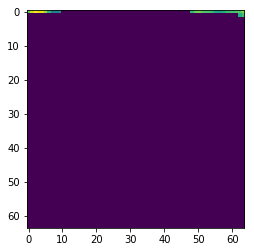

row start: 1466, row end: 1530
col start: 2880, col end: 2944
imshape: (2352, 3231)


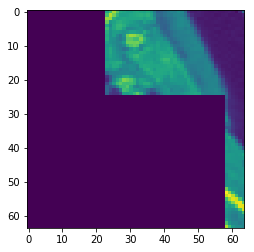

row start: 1194, row end: 1258
col start: 1482, col end: 1546
imshape: (2352, 3231)


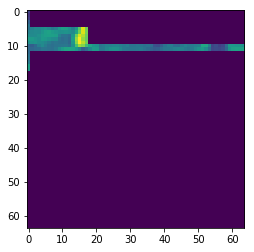

row start: 2085, row end: 2149
col start: 2947, col end: 3011
imshape: (2352, 3231)


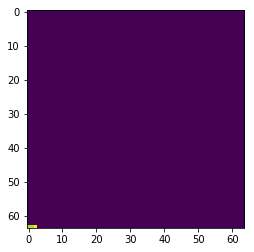

row start: 1411, row end: 1475
col start: 2461, col end: 2525
imshape: (2352, 3231)


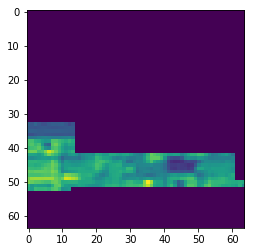

row start: 1457, row end: 1521
col start: 2111, col end: 2175
imshape: (2352, 3231)


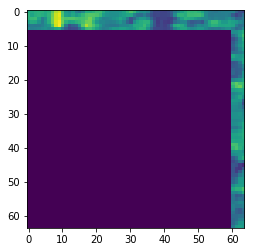

In [18]:
##### debug code for DG support
from gbdxtools import CatalogImage
import numpy as np
from matplotlib import pyplot as plt

# get the dask array for the 8 band MS image
shp_bounds = (-105.04798605513851, 39.690173358281925, -104.99237692378261, 39.73066280731016)
dg_scene_id = '1030010057062200'
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)

# load the row/cols
coords = np.loadtxt('dg_support_coords.txt')

samp_inds = np.unique(np.random.randint(6000, size=100))
for ind in samp_inds:
    
    r,c = coords[ind]
    r = int(r)
    c = int(c)
    window_size=64
    r_start = int(r - window_size/2)
    r_end = int(r_start + window_size)
    c_start = int(c - window_size/2)
    c_end = int(c_start + window_size)
    
    print('row start: {}, row end: {}'.format(r_start, r_end))
    print('col start: {}, col end: {}'.format(c_start, c_end))
    print('imshape: {}'.format(img_2m.shape[1:]))
    
    test = img_2m[:,r_start:r_end, c_start:c_end]
    plt.imshow(test[5,:,:])
    plt.show()